In [1]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation

from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import MeanSquaredError

import numpy as np

from tensorflow.keras.datasets import mnist

In [2]:
# We define an Auto Encoder class that has the methods for creation of Encoder Decoder Architecture
# We define the methods that will enable building of the Convolutional Auto Encoder
class AE:
    
    # Initialize the AutoEncoder by defining
    # Input Shape - Shape of the data, in this case [28,28,1]
    # Convolutional Filters - number of filters for each Conv layer
    # Latent Space - Encoding Space
    def __init__(self,
                 input_shape,
                 conv_filters,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.latent_space_dim = latent_space_dim # 2

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None # This will be useful when constructing the decoder
        self._model_input = None

        self._build()

    def _build(self):
        self._build_encoder() # Build the Encoder Model
        self._build_decoder() # Build the Decoder Model
        self._build_autoencoder() # Build Autoencoder

    def _build_encoder(self):
        # Encoder is created in the following sequence
        # 1. Encoder Input
        # 2. 1..N convolution layers
        # 3. Bottleneck Layer
        # Layers from Input to Bottleneck
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        # Create all convolutional layers in encoder
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        #Add a convolutional layer to a graph of layers, consisting of        
        #conv 2d + ReLU + batch normalization.
        # Kernel Size = 3 and Strides = 1 is fixed
        
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=3,
            strides=1,
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        # Flatten data and add bottleneck (Dense layer).
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        x = Dense(self.latent_space_dim, name="encoder_output")(x)
        return x

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        # Add conv transpose blocks.
        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=3,
            strides=1,
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=1,
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")
    
    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()
    
    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        mse_loss = MeanSquaredError()
        self.model.compile(optimizer=optimizer, loss=mse_loss)

    def train(self, x_train, batch_size, num_epochs):
        history = self.model.fit(x_train,
                       x_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)
        return history
    def predict(self, x_test):
        return self.model.predict(x_test)


In [3]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255
X_test = X_test/255

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

In [6]:
X_train.shape

(60000, 28, 28, 1)

In [7]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [8]:
autoencoder = AE(
        input_shape=(28, 28, 1),
        conv_filters=(32, 64, 64, 64),
        latent_space_dim=32)

In [9]:
autoencoder.compile(LEARNING_RATE)

In [10]:
autoencoder.train(x_train=X_train, batch_size=BATCH_SIZE, num_epochs=EPOCHS)

Epoch 1/20
1875/1875 [==============================] - 36s 14ms/step - loss: 0.0098
Epoch 2/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0039
Epoch 3/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0034
Epoch 4/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0031
Epoch 5/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0028
Epoch 6/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0026
Epoch 7/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0025
Epoch 8/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0024
Epoch 9/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0023
Epoch 10/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0022
Epoch 11/20
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0021
Epoch 12/20
1875/1875 [==============================] - 27s 14

In [11]:
final_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 2s 5ms/step


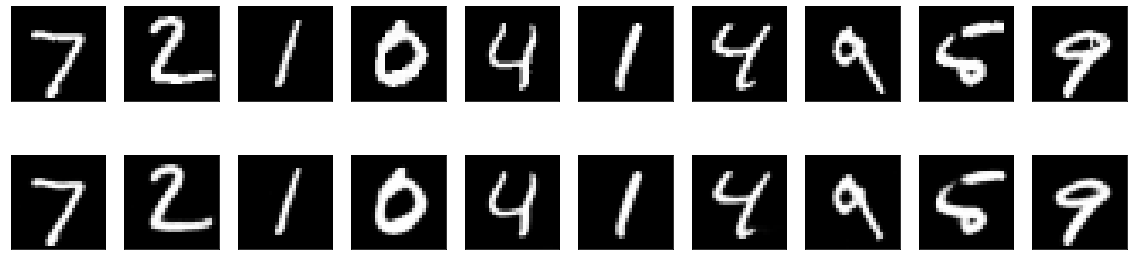

In [12]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Layers
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(final_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 28, 28, 32)       320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 28, 28, 32)       128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 28, 28, 64)       18496     
 D)                                                              
                                                           